<a href="https://colab.research.google.com/github/devkaps-tech/FaceRecognition-Using-One-Shot-Learning/blob/main/FaceRecognistion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
ANC_PATH = '/content/gdrive/MyDrive/AIR/data/anchor'
POS_PATH = '/content/gdrive/MyDrive/AIR/data/positive'
NEG_PATH = '/content/gdrive/MyDrive/AIR/data/negative'


In [ ]:
 ANC_PATH+'\*.jpg'

'/content/gdrive/MyDrive/AIR/data/anchor\\*.jpg'

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)


In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
dir_test

In [ ]:
print(dir_test.next())

b'/content/gdrive/MyDrive/AIR/data/anchor/12b4c2f2-4872-11ed-b847-b068e64dc175.jpg'


In [ ]:
def preprocess(file_path):
    
   
    byte_img = tf.io.read_file(file_path)
   
    img = tf.io.decode_jpeg(byte_img)
    
 
    img = tf.image.resize(img, (100,100))
    
    img = img / 255.0

    
    return img

In [ ]:
img = preprocess('/content/gdrive/MyDrive/AIR/data/anchor/062b9e36-4872-11ed-864e-b068e64dc175.jpg')

In [ ]:
img.numpy().max() 

0.8634804

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()

In [ ]:
exampple = samples.next()

In [ ]:
exampple

(b'/content/gdrive/MyDrive/AIR/data/anchor/0d7480ef-4872-11ed-af07-b068e64dc175.jpg',
 b'/content/gdrive/MyDrive/AIR/data/positive/d446aac6-4871-11ed-9373-b068e64dc175.jpg',
 1.0)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*exampple)
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.37132353, 0.30857843, 0.32034314],
         [0.37083334, 0.30416667, 0.32769608],
         [0.36838236, 0.30171567, 0.3252451 ],
         ...,
         [0.21862745, 0.13529412, 0.15294118],
         [0.22671568, 0.14044118, 0.15220588],
         [0.23431373, 0.13627452, 0.15196079]],
 
        [[0.38112745, 0.30661765, 0.32034314],
         [0.37156862, 0.30514705, 0.31862745],
         [0.37965685, 0.30661765, 0.32818627],
         ...,
         [0.22818628, 0.1367647 , 0.15808824],
         [0.22965686, 0.14044118, 0.15367647],
         [0.22941177, 0.13137256, 0.14705883]],
 
        [[0.38333333, 0.30588236, 0.3137255 ],
         [0.3735294 , 0.2990196 , 0.30735293],
         [0.3767157 , 0.3022059 , 0.3120098 ],
         ...,
         [0.24509804, 0.14264706, 0.16838235],
         [0.22867647, 0.13063726, 0.14828432],
         [0.21862745, 0.12941177, 0.14215687]],
 
        ...,
 
        [[0.29240197, 0.2492647 

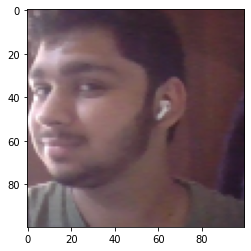

In [ ]:
plt.imshow(res[1])

In [ ]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [ ]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [ ]:
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
input_image

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_img')>

In [ ]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [ ]:
l1 = L1Dist()
l1.call(inp_embedding , val_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'tf.math.abs')>

In [ ]:
siamese_layer = L1Dist()

In [ ]:
distances = siamese_layer(inp_embedding, val_embedding)

In [ ]:
classifier = Dense(1, activation='sigmoid')(distances)

In [ ]:
def make_siamese_model(): 
    
    input_image = Input(name='input_img', shape=(100,100,3))
    
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distances)

  
    
    return  Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = '/content/gdrive/MyDrive/AIR/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_network)

In [ ]:
test_batch = train_data.as_numpy_iterator()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [ ]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
epochs = 50
train(train_data , epochs)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 248s 329ms/step
0.3160437 0.6256158 1.0

 Epoch 2/50
27/27 [==============================] - 8s 297ms/step
0.09064928 0.9809524 1.0

 Epoch 3/50
27/27 [==============================] - 8s 295ms/step
0.08473271 0.98642534 1.0

 Epoch 4/50
27/27 [==============================] - 8s 279ms/step
0.132973 0.995283 1.0

 Epoch 5/50
27/27 [==============================] - 8s 292ms/step
0.10715787 1.0 0.9951923

 Epoch 6/50
27/27 [==============================] - 8s 280ms/step
0.0020642523 1.0 0.9950739

 Epoch 7/50
27/27 [==============================] - 8s 311ms/step
0.0069324677 1.0 0.9951456

 Epoch 8/50
27/27 [==============================] - 8s 303ms/step
0.00047101482 1.0 1.0

 Epoch 9/50
27/27 [==============================] - 8s 287ms/step
0.07923029 0.96568626 1.0

 Epoch 

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[9.9998176e-01],
       [9.9992990e-01],
       [2.0116058e-06],
       [1.3859633e-06],
       [9.9960774e-01],
       [2.4947906e-06],
       [2.2329789e-06],
       [1.0000000e+00],
       [3.7219581e-06],
       [3.5632017e-06],
       [2.7143440e-07],
       [1.0000000e+00],
       [9.9999976e-01],
       [9.9999976e-01],
       [9.6248350e-06],
       [5.9146316e-08]], dtype=float32)

In [ ]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0]

In [ ]:
y_true

array([1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 
print("Recall is ",r.result().numpy())
print("Precision is", p.result().numpy())

Recall is  1.0
Precision is 1.0


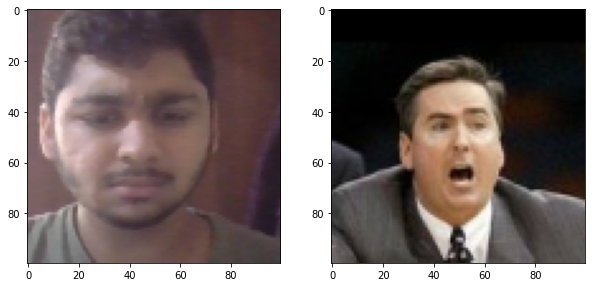

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[1])

plt.subplot(1,2,2)
plt.imshow(test_val[1])

plt.show()


In [ ]:
siamese_model.save('siamesemodelv2.h5')

In [ ]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
siamese_model.predict([test_input, test_val])

array([[1.0000000e+00],
       [9.3582933e-08],
       [1.0000000e+00],
       [1.6600463e-06]], dtype=float32)

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][